In [1]:
# import libraries

'''
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
'''

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# These are all the imports needed for the assignment
%matplotlib inline

# Import nltk package (Natural Language Toolkit)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

# scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [2]:
import pyspark

In [3]:
import dask.dataframe as dd

In [4]:
# Download the NLTK English tokenizer and the stopwords of all languages
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\19495\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\19495\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

client = boto3.client(
    's3',
    aws_access_key_id = 'sukiK@2002',
    aws_secret_access_key = 'sukik',
    region_name = 'ap-west-1'
)

In [5]:
files = ['amazon_reviews_us_Electronics_v1_00.tsv', \
         'amazon_reviews_us_Gift_Card_v1_00.tsv', \
         'amazon_reviews_us_Major_Appliances_v1_00.tsv', \
         'amazon_reviews_us_Office_Products_v1_00.tsv', \
         'amazon_reviews_us_Shoes_v1_00.tsv', \
         'amazon_reviews_us_Toys_v1_00.tsv', \
         'amazon_reviews_us_Watches_v1_00.tsv']

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [7]:
columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', \
           'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
elec_df = pd.read_csv("C:/Users/19495/DS3ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", names = columns, sep = '\t').iloc[1:,:]
# 'fars_data/' + files[0]
elec_df = elec_df.sample(n = 2_000_000)
# 200000

columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
len(columns)

one_file = pd.read_csv('fars_data/' + files[0], names = columns, sep = '\t').iloc[1:,:]
one_file.head()

one_file.shape[0]+1

In [8]:
one_file = elec_df

## Data Sampling

In [9]:
def df_sampling(df):
    # Since we know that there are more unverified than verified --> we sample based on that
    
    # Since there are no data values in 'verified_purchase' columns that deviate from 'Y' or 'N' we proceed
    verified_count_df = df[df['verified_purchase'] == 'Y']
    unverified_count_df = df[df['verified_purchase'] == 'N']
    
    print("Number of verified purchases:", len(verified_count_df))
    print("Number of unverified purchases:", len(unverified_count_df))
    
    sample_len = len(unverified_count_df)
    
    verified_sample_df = verified_count_df.sample(n = sample_len)
    unified_df = pd.concat([unverified_count_df, verified_sample_df])
    
    print("Number of verified purchases (balanced dataset):", len(unified_df[unified_df['verified_purchase'] == 'Y']))
    print("Number of unverified purchases (balanced dataset):", len(unified_df[unified_df['verified_purchase'] == 'N']))
    
    return unified_df

#test.rename(columns=test.iloc[0])
training_data = pd.DataFrame() #initialize an empty dataframe
testing_data = pd.DataFrame()

one_file = pd.read_csv(data_location + files[1], names = columns, sep = '\t').iloc[1:,:]

In [10]:
one_file.shape

(2000000, 15)

In [11]:
balanced_elec = df_sampling(one_file)
display(balanced_elec.head())

Number of verified purchases: 1680632
Number of unverified purchases: 319368
Number of verified purchases (balanced dataset): 319368
Number of unverified purchases (balanced dataset): 319368


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2128626,US,50635360,R3GEBQ69FWP4P8,B006Q4NSK8,13679975,AKG K3003I Reference Class 3-Way Earphones with Mic and Control (Black/Silver),Electronics,5,38,44,N,N,Amazing sound for an astronomical price,"The AKG K3003I is a pretty amazing piece of audio gear. As far as universal fit IEMs go, it's comparable with the FitEar ToGo 334 and the Sennheiser IE800s (I own both) but slightly more revealing. Imaging and soundstage are fantastic. Works well without benefit of headphone amp (compelling sound straight from iPod/iPhone)<br /><br />In a different league than Westone 4, Schure 535 and Sennheiser IE80s but not by 2x (i.e., law of diminishing returns: price vs performance.)<br /><br />The downside? Price, cabling (seems delicate/not user-replaceable) and therefore IEMs that you might not want to use in a mobile context for fear of breakage.",2013-02-05
744165,US,1065728,R4QF351TNH33A,B0040DGUVG,16335269,HDMI CABLE VARIATION,Electronics,5,0,0,N,N,Five Stars,Is the best for the price,2015-01-15
2569858,US,16556148,R2ZQRZYYXEC6AA,B000EUGX70,424464879,Logitech Harmony 550 Remotes,Electronics,2,0,1,N,N,Not intuitive and buttons do not work after a few months,"The setup and design of this remote is not very intuitive. The computer interface requires navigation through multiple screens and many of my products required quite a bit of playing around before they worked like I wanted. However, after a few hours of setup, most things worked fine. My biggest gripe though is that about a year after buying this remote, many of the buttons don't work. In fact, pretty much all of the buttons we use on a regular basis are completely useless. This despite the fact that we have taken extremely good care of it and it still looks like new. Also, a number of our electronics aren't supported by the remote such as our Sony Google Bluray. I'm sure it would function with a lot of work on my end but since the buttons don't work it would be a waste of effort. I am very unsatisfied with this purchase.",2011-07-02
2781187,US,14610879,R1OGESYWKU20SP,B00140DBRY,296882964,Sony SRF-M37W Walkman Digital Tuning Weather/FM/AM Stereo Radio (Black),Electronics,1,11,19,N,N,More junk from China.,"Sony used to have a great reputation for high quality products. But these are junk.<br /><br />The headphones broke in about 3 weeks.<br />The battery compartment door is flimsy and the battery falls out especially if you drop it from a small height.<br />The ability to separate FM stations is pathetic; various other stations -not even close on the dial- constantly break in.<br />The ability to receive FM stations is pathetic. I can walk behind my house and suddenly get static. I go a few miles down the road and have zero reception of any station. Indoors, such as using a bathroom on my walking route, and I get static.<br />The weather radio reception is close to nonexistent.<br /><br />Battery life, using a rechargeable AAA, is good enough for my purpose, maybe 8 hours or so, but hardly outstanding.<br /><br />I haven't found a replacement for these yet, based on reviews from this site everything seems to be junk. But, I wouldn't buy this version for sure.",2009-12-22
2964781,US,40825723,RB7U1F2YT2ZDE,B000J13TEE,199115294,Sangean HDT-1 HD Radio Component Tuner (Discontinued by Manufacturer),Electronics,5,1,2,N,N,"GOOD PRODUCT, FAIRLY PRICED, GREAT DIGITAL SOUND","PERHAPS THIS IS THE ONLY TUNER IN THE MARKET UNDER $.200. SET UP IS EASY AND QUICK. ONLY THING YOU MAY NEED AN AMP OR A RECEIVER WITH ADEQUATE INPUTS.. RECEPTION IS EXCELLENT SINCE, I LIVE OUTSIDE WASHINGTON DC. THE SOUND IS OBVIOUSLY DIGITAL AND IT IS ALMOST CLOSE TO THE FULL AUDIO SPECTRUM. A GOOD BUY FROM SANGEAN WHO IS POPULAR FOR SHORT WAVE RADIOS. IF ONE WISHES TO FIND THE STATIONS EITHER HE OR SHE COULD SCAN THE HD SECTION OF

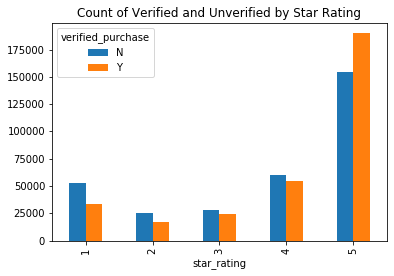

In [12]:
balanced_elec['star_rating'] = balanced_elec['star_rating'].apply(int)
cond_count_m = balanced_elec.pivot_table(index='star_rating', 
                     columns='verified_purchase',
                     values='customer_id',
                     aggfunc='count')

file_path = "C:/Users/19495/DS3ProjectFiles/"
cond_count_m.plot(kind = "bar", title = 'Count of Verified and Unverified by Star Rating')
plt.savefig(file_path + 'KNNElectronicsStar(1).png', bbox_inches='tight', transparent=False)

In [13]:
one_file = balanced_elec.copy()

### Type Conversion and Exploration

In [14]:
def convert_to_int(x):
    return int(float(x))

In [15]:
#convert all mixed datatypes --> string objects (unable to convert to int)
one_file['customer_id'] = one_file['customer_id'].apply(int) #1
one_file['product_parent'] = one_file['product_parent'].apply(int) #4
one_file['star_rating'] = one_file['star_rating'].apply(int) #7
one_file['helpful_votes'] = one_file['helpful_votes'].apply(int) #8
one_file['total_votes'] = one_file['total_votes'].apply(int) #9

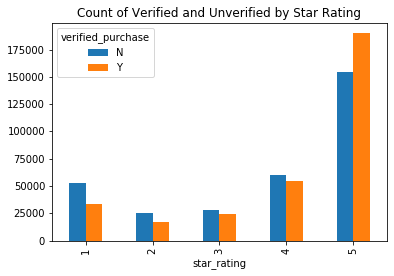

In [16]:
elec_stars = one_file.groupby('star_rating')['verified_purchase'].count() 
#/ (len(cleaned_nypd) - cleaned_nypd['complainant_ethnicity'].isna().sum())
#com_ethn_gby.plot(kind = "barh", title = 'Count of Each Complainant Ethnicities')
elec_stars
cond_count_m = one_file.pivot_table(index='star_rating', 
                     columns='verified_purchase',
                     values='customer_id',
                     aggfunc='count')
cond_count_m
cond_count_m.plot(kind = "bar", title = 'Count of Verified and Unverified by Star Rating')

one_file.isnull().sum().sort_values(ascending=False)

one_file.dropna(inplace=True) #drop all of the missing values
one_file.isnull().sum().sort_values(ascending=False)

In [17]:
#there may be tabs in the review that is what is leading to the excluded cases when converting to df

'''
train_data['verified_purchase'].value_counts()
test_data['verified_purchase'].value_counts()
'''

one_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2128626,US,50635360,R3GEBQ69FWP4P8,B006Q4NSK8,13679975,AKG K3003I Reference Class 3-Way Earphones with Mic and Control (Black/Silver),Electronics,5,38,44,N,N,Amazing sound for an astronomical price,"The AKG K3003I is a pretty amazing piece of audio gear. As far as universal fit IEMs go, it's comparable with the FitEar ToGo 334 and the Sennheiser IE800s (I own both) but slightly more revealing. Imaging and soundstage are fantastic. Works well without benefit of headphone amp (compelling sound straight from iPod/iPhone)<br /><br />In a different league than Westone 4, Schure 535 and Sennheiser IE80s but not by 2x (i.e., law of diminishing returns: price vs performance.)<br /><br />The downside? Price, cabling (seems delicate/not user-replaceable) and therefore IEMs that you might not want to use in a mobile context for fear of breakage.",2013-02-05
744165,US,1065728,R4QF351TNH33A,B0040DGUVG,16335269,HDMI CABLE VARIATION,Electronics,5,0,0,N,N,Five Stars,Is the best for the price,2015-01-15
2569858,US,16556148,R2ZQRZYYXEC6AA,B000EUGX70,424464879,Logitech Harmony 550 Remotes,Electronics,2,0,1,N,N,Not intuitive and buttons do not work after a few months,"The setup and design of this remote is not very intuitive. The computer interface requires navigation through multiple screens and many of my products required quite a bit of playing around before they worked like I wanted. However, after a few hours of setup, most things worked fine. My biggest gripe though is that about a year after buying this remote, many of the buttons don't work. In fact, pretty much all of the buttons we use on a regular basis are completely useless. This despite the fact that we have taken extremely good care of it and it still looks like new. Also, a number of our electronics aren't supported by the remote such as our Sony Google Bluray. I'm sure it would function with a lot of work on my end but since the buttons don't work it would be a waste of effort. I am very unsatisfied with this purchase.",2011-07-02
2781187,US,14610879,R1OGESYWKU20SP,B00140DBRY,296882964,Sony SRF-M37W Walkman Digital Tuning Weather/FM/AM Stereo Radio (Black),Electronics,1,11,19,N,N,More junk from China.,"Sony used to have a great reputation for high quality products. But these are junk.<br /><br />The headphones broke in about 3 weeks.<br />The battery compartment door is flimsy and the battery falls out especially if you drop it from a small height.<br />The ability to separate FM stations is pathetic; various other stations -not even close on the dial- constantly break in.<br />The ability to receive FM stations is pathetic. I can walk behind my house and suddenly get static. I go a few miles down the road and have zero reception of any station. Indoors, such as using a bathroom on my walking route, and I get static.<br />The weather radio reception is close to nonexistent.<br /><br />Battery life, using a rechargeable AAA, is good enough for my purpose, maybe 8 hours or so, but hardly outstanding.<br /><br />I haven't found a replacement for these yet, based on reviews from this site everything seems to be junk. But, I wouldn't buy this version for sure.",2009-12-22
2964781,US,40825723,RB7U1F2YT2ZDE,B000J13TEE,199115294,Sangean HDT-1 HD Radio Component Tuner (Discontinued by Manufacturer),Electronics,5,1,2,N,N,"GOOD PRODUCT, FAIRLY PRICED, GREAT DIGITAL SOUND","PERHAPS THIS IS THE ONLY TUNER IN THE MARKET UNDER $.200. SET UP IS EASY AND QUICK. ONLY THING YOU MAY NEED AN AMP OR A RECEIVER WITH ADEQUATE INPUTS.. RECEPTION IS EXCELLENT SINCE, I LIVE OUTSIDE WASHINGTON DC. THE SOUND IS OBVIOUSLY DIGITAL AND IT IS ALMOST CLOSE TO THE FULL AUDIO SPECTRUM. A GOOD BUY FROM SANGEAN WHO IS POPULAR FOR SHORT WAVE RADIOS. IF ONE WISHES TO FIND THE STATIONS EITHER HE OR SHE COULD SCAN THE HD SECTION OF

#to check te datatypes within each column

print(train_data.applymap(type))
data_types = train_data.applymap(type)

In [18]:
#the number of customers that gave multiple reviews
#may be valueable to investigate
one_file.groupby('customer_id').count()['marketplace'].sort_values(ascending = False).value_counts()

1      498937
2       38477
3        7842
4        2585
5        1152
6         598
7         392
8         268
9         171
10        131
11         95
13         73
12         68
14         54
16         33
15         31
19         28
17         26
18         18
20         17
23         16
21         15
22         13
24         11
27          8
28          5
30          5
26          5
35          4
32          4
34          4
56          3
92          3
31          3
39          3
25          3
37          3
64          2
41          2
42          2
62          2
60          2
78          2
29          2
134         1
33          1
61          1
103         1
100         1
97          1
90          1
89          1
73          1
72          1
70          1
68          1
67          1
63          1
58          1
111         1
54          1
53          1
49          1
48          1
47          1
46          1
45          1
44          1
43          1
40          1
38          1
36    

In [19]:
one_file['star_rating'].value_counts()

5    344198
4    114483
1     86190
3     51790
2     42075
Name: star_rating, dtype: int64

## Data Cleaning

In [20]:
# Import re for text cleaning purposes
import re

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\19495\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\19495\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
def df_cleaning(df, col):
    # Drop rows with na values
    df.dropna(inplace = True)
    
    new_col_name = 'new_' + col
    
    df[new_col_name] = df[col].copy() 
    
    # Remove unwanted formatting characters
    format_strs = dict.fromkeys(['<br /><br />', '&#34', 'br', '&quot', '<br />'], ' ')
    
    for key in format_strs:
        df[new_col_name] = df[new_col_name].apply(lambda review: review.replace(key, format_strs[key]))
    # removing quotes produces smthg like this --> 'The product has great ;sound; --> we must remove punctuation

    
    # Case normalization (lower case)
    df[new_col_name] = df[new_col_name].str.lower()
    
    remove_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",
                   "(": "", ")":""}
    for key, val in remove_dict.items():
        df[new_col_name] = df[new_col_name].apply(
            lambda x: x.replace(key, val))
        
    # Remove stopwords
    stop_lst = stopwords.words('english')
    #stop_lst += (["can't", "i'm" "i'd", "i've", "i'll", "that's", "there's", "they're"])
    # ****Do we not have to take stopwords out BEFORE removing punctuation? Otherwise words with punct like “cant” remains there
    df[new_col_name] = df[new_col_name].apply(lambda text_body: " ".join([word for word in text_body.split() if word not in (stop_lst)]))
    
    # Removing Unicode Chars (punctuation, URL, @)
    df[new_col_name] = df[new_col_name].apply(lambda rev: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", rev))
    
    # Lemmatization
    word_lemmatizer = WordNetLemmatizer()
    df[new_col_name] = df[new_col_name].apply(lambda txt: " ".join([(word_lemmatizer.lemmatize(word)) for word in txt.split()]))
    
    return df

cleaned = df_cleaning(one_file)

In [22]:
cleaned2 = df_cleaning(one_file, 'review_body')

In [23]:
#cleaned2.get(['review_body', 'new_review_body']).head()

In [24]:
cleaned2 = df_cleaning(one_file, 'review_headline')

In [25]:
cleaned2.get(['review_headline', 'new_review_headline']).head()

,review_headline,new_review_headline
2128626,Amazing sound for an astronomical price,amazing sound astronomical price
744165,Five Stars,five star
2569858,Not intuitive and buttons do not work after a few months,intuitive button work month
2781187,More junk from China.,junk china
2964781,"GOOD PRODUCT, FAIRLY PRICED, GREAT DIGITAL SOUND",good product fairly priced great digital sound


In [26]:
cleaned2 = df_cleaning(one_file, 'product_title')

In [27]:
cleaned2.get(['product_title', 'new_product_title']).head()

,product_title,new_product_title
2128626,AKG K3003I Reference Class 3-Way Earphones with Mic and Control (Black/Silver),akg ki reference class way earphone mic control blacksilver
744165,HDMI CABLE VARIATION,hdmi cable variation
2569858,Logitech Harmony 550 Remotes,logitech harmony remote
2781187,Sony SRF-M37W Walkman Digital Tuning Weather/FM/AM Stereo Radio (Black),sony srfmw walkman digital tuning weatherfmam stereo radio black
2964781,Sangean HDT-1 HD Radio Component Tuner (Discontinued by Manufacturer),sangean hdt hd radio component tuner discontinued manufacturer


In [28]:
cleaned2.iloc[0].get('review_body')

"The AKG K3003I is a pretty amazing piece of audio gear. As far as universal fit IEMs go, it's comparable with the FitEar ToGo 334 and the Sennheiser IE800s (I own both) but slightly more revealing.  Imaging and soundstage are fantastic.  Works well without benefit of headphone amp (compelling sound straight from iPod/iPhone)<br /><br />In a different league than Westone 4, Schure 535 and Sennheiser IE80s but not by 2x (i.e., law of diminishing returns: price vs performance.)<br /><br />The downside?  Price, cabling (seems delicate/not user-replaceable) and therefore IEMs that you might not want to use in a mobile context for fear of breakage."

## Vader Sentiment Analysis

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def get_sentiment_scores(review):
    """
    create new dataframe with just the proportions for each review
    four columns
    neg_prop, pos_prop, neu_prop, compound_prop and will contain these values
    obtained from the vator sentiment algorithm
    """
    snt = analyser.polarity_scores(review)
    #print(f"{sentence} {str(snt)}")
    return snt

In [30]:
get_sentiment_scores(cleaned2.iloc[0].get('review_body')) #without lemmitization

{'neg': 0.093, 'neu': 0.764, 'pos': 0.143, 'compound': 0.6183}

In [31]:
get_sentiment_scores(cleaned2.iloc[0].get('new_review_body')) #with lemmitization

{'neg': 0.098, 'neu': 0.641, 'pos': 0.26, 'compound': 0.8915}

In [32]:
one_file = cleaned2

In [33]:
one_file['rev_dict'] = one_file['new_review_body'].apply(get_sentiment_scores)

In [34]:
def get_neg(review_dict):
    return review_dict['neg']

def get_neu(review_dict):
    return review_dict['neu']

def get_pos(review_dict):
    return review_dict['pos']

def get_compound(review_dict):
    return review_dict['compound']

def only_compound(x):
    dct = get_sentiment_scores(x)
    return dct['compound']

In [35]:
#get neg prop
one_file['neg_prop'] = one_file['rev_dict'].apply(get_neg)
#get neu prop
one_file['neu_prop'] = one_file['rev_dict'].apply(get_neu)
#get pos prop
one_file['pos_prop'] = one_file['rev_dict'].apply(get_pos)
#get compound prop
one_file['compound_prop'] = one_file['rev_dict'].apply(get_compound)

In [36]:
#save the dataframe as a csv file
#one_file.to_csv('electronics_data_cleaned.csv')

### Sentiment Analysis

#df is all data other than rating 3
df = one_file[one_file['star_rating'] != 3]

df['star_rating'].value_counts()

df['positively_rated'] = np.where(df['star_rating'] > 3, 1, 0)

df['positively_rated'].value_counts()

sns.countplot(df['positively_rated'])

##### On all of the data

train_data, test_data = np.split(one_file.sample(frac=1, random_state=1729), [int(0.7 * len(one_file))])
print(train_data.shape, test_data.shape)

X_train = train_data['review_body']
X_train.iloc[0] #to_frame()

Y_train = train_data['star_rating']

X_test = test_data['review_body']
Y_test = test_data['star_rating']

#### TF-IDF - to get predictions of what star rating will be based on text of review

from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer().fit(X_train)

len(vect.get_feature_names()) #unique words

X_train_vect = vect.transform(X_train)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vect, Y_train)

predictions = model.predict(vect.transform(X_test))

len(predictions)

###### Confusion Matrix - shows probabilities for whether cat data is predicted correctly

In [37]:
def plot_confusion_matrix_2(cm, target_names,
                          fname, epoch,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, target=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    plt.style.use('default')

    # # only true if it weren't normalized:
    # accuracy = np.trace(cm) / float(np.sum(cm))
    # misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    if target == "rule-based":
        plt.title(title + ' for rule-based PF')
    else:
        plt.title(title + ' for MLPF at epoch ' + str(epoch))

    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlim(-1, len(target_names))
    plt.ylim(-1, len(target_names))
    plt.xlabel('Predicted label')
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.savefig(fname + '.png')
    plt.savefig(fname + '.pdf')
    #plt.close(fig)

    return fig, ax

### SVM Notes

- **Bag of Words (BoW)**
        - BoW encodes an input sentence as the frequency of each word in the sentence. 
        - In this approach, all words contribute equally to the feature vectors.
- **Term Frequency - Inverse Document Frequency (TF-IDF)**
        - TF-IDF is a measure of how important each term is to a specific document, as compared to an overall corpus. 
        - TF-IDF encodes each word as its frequency in the document of interest, divided by a measure of how common the word is across all documents (the corpus).
        - Using this approach, each word contributes differently to the feature vectors.
        - The assumption behind using TF-IDF is that words that appear commonly everywhere are not that informative about what is specifically interesting about a document of interest, so it is tuned to representing a document in terms of the words it uses that are different from other documents. 

- To compare those 2 methods, we will first apply them on the same dataset to analyse sentiment (how positive or negative a text is). In order to make the comparison fair, an **SVM (support vector machine)** classifier will be used to classify positive reviews and negative reviews.

- SVM is a simple yet powerful and interpretable linear model. To use it as a classifier, we need to have at least 2 splits of the data: training data and test data. The training data is used to tune the weight parameters in the SVM to learn an optimal way to classify the training data. We can then test this trained SVM classifier on the test data, to see how well it works on data that the classifier has not seen before. 

We will now create a CountVectorizer object to transform the text data into vectors with numerical values.

To do so, we will initialize a CountVectorizer object, and name it as vectorizer.

4 arguments to initialize a CountVectorizer:

* analyzer: 'word'
 Specify to analyze data from word-level.
 
* max_features: 2000
 Set a max number of unique words.
 
* tokenizer: word_tokenize
 Set to tokenize the text data by using the word_tokenizer from NLTK .
 
* stop_words: stopwords.words('english')
 Set to remove all stopwords in English. We do this since they generally don't provide useful discriminative information.

## KNN

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [39]:
one_file.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'new_review_body',
       'new_review_headline', 'new_product_title', 'rev_dict', 'neg_prop',
       'neu_prop', 'pos_prop', 'compound_prop'],
      dtype='object')

In [40]:
def convert_to_id(x):
    alphabet = {'a': 1, 'c': 3, 'b': 2, 'e': 5, 'd': 4, 'g': 7, 'f': 6, 'i': 9, 'h': 8, 'k': 11, 'j': 10, 'm': 13, 'l': 12, 'o': 15, 'n': 14, 'q': 17, 'p': 16, 's': 19, 'r': 18, 'u': 21, 't': 20, 'w': 23, 'v': 22, 'y': 25, 'x': 24, 'z': 26}
    out = ''
    for i in x:
        if i.lower() in alphabet.keys():
            out += str(alphabet[i.lower()])
        else:
            out += i
    return out

In [41]:
one_file['product_id_convert'] = one_file.get("product_id").apply(convert_to_id)

In [42]:
one_file['product_category_convert'] = one_file.get("product_category").apply(convert_to_id)

In [43]:
one_file['prod_title_comp'] = one_file.get("new_product_title").apply(only_compound)

In [44]:
one_file['rev_title_comp'] = one_file.get("new_review_headline").apply(only_compound)

def help_prop(vals):
    if vals[1] == 0:
        return 0.5
    else:
        return vals[0] / vals[1]

In [45]:
def helpful_prop(df):  
    vote_series = pd.Series(df['helpful_votes'] / df['total_votes'])
    # !! All nan values in votes_prop should be changed to zero: this means that 0/0 occurred !!
    vote_series = vote_series.fillna(0)
    return vote_series

In [46]:
#NEED TO THINK OF WHAT WOULD HAPPEN IF THE NUMBER OF TOTAL VOTES WOULD BE 0
one_file['help_prop'] = helpful_prop(one_file)
# one_file.get("helpful_votes") / one_file.get("total_votes")
#one_file['help_prop'] = one_file.get("helpful_votes").apply(help_prop)

In [47]:
#one_file.iloc[2].to_frame()

In [48]:
def id_for_dictionary(dic):
    if len(dic) == 4:
        ind = list(dic.values()).index(max(list(dic.values())[0:-1])) #remove the compound
    else:
        ind = list(dic.values()).index(max(list(dic.values())))
        
    if ind == 1:
        return 0
    elif ind == 0:
        return -1
    else:
        return 1

In [49]:
def id_for_prop(prop):
    if prop < 0.45:
        return -1
    elif prop > 0.55:
        return 1
    else:
        return 0

In [50]:
one_file['rev_bod_id'] = one_file.get("rev_dict").apply(id_for_dictionary)

In [51]:
one_file['help_prop_id'] = one_file.get("help_prop").apply(id_for_prop)

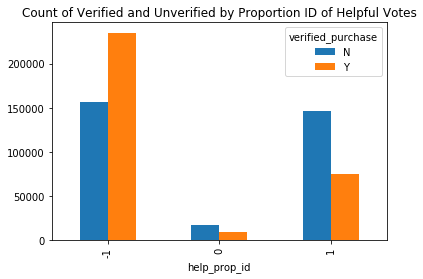

In [52]:
cond_count_m = one_file.pivot_table(index='help_prop_id', 
                     columns='verified_purchase',
                     values='customer_id',
                     aggfunc='count')
#cond_count_m
cond_count_m.plot(kind = "bar", title = 'Count of Verified and Unverified by Proportion ID of Helpful Votes')

find percentages for the body -- text and display those in a column -- act as labels for the percent positivity of the review body and header themselves

In [53]:
#imp_col = one_file[['verified_purchase', 'prod_title_comp', 'star_rating', 'rev_title_comp', 'neg_prop', 'neu_prop', 'pos_prop', 'help_prop']]
imp_col = one_file[['verified_purchase', 'prod_title_comp', 'star_rating', 'rev_title_comp', 'rev_bod_id', 'help_prop_id']]

In [54]:
imp_col.dtypes

verified_purchase     object
prod_title_comp      float64
star_rating            int64
rev_title_comp       float64
rev_bod_id             int64
help_prop_id           int64
dtype: object

In [55]:
#need to replace review_body and review_headline with percentages for sentiment -- easier to use for classification
#vine needs to be converted to a yes/no binary column similar to how positively rated was determined
#use original dataset with rating 3 available

#X = imp_col.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]].values
X = imp_col.iloc[:, [1,2,3,4,5]].values #only taking in the categories that will be used as a dataframe
y = imp_col.iloc[:, 0].values

"""
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:,1] = le.fit_transform(X[:,1])
"""

'\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\nX[:,1] = le.fit_transform(X[:,1])\n'

In [56]:
X

array([[ 0.    ,  5.    ,  0.5859,  0.    ,  1.    ],
       [ 0.    ,  5.    ,  0.    ,  1.    , -1.    ],
       [ 0.4019,  2.    ,  0.    ,  0.    , -1.    ],
       ...,
       [ 0.    ,  5.    ,  0.9998,  0.    , -1.    ],
       [ 0.    ,  4.    ,  0.6249,  0.    ,  1.    ],
       [ 0.2732,  5.    ,  0.    ,  0.    , -1.    ]])

#Since our dataset containing character variables we have to encode it using LabelEncoder

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:,2] = le.fit_transform(X[:,2])

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [58]:
# Next, we are doing feature scaling to the training and test set of independent variables for reducing the size to smaller values
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [59]:
from sklearn.neighbors import KNeighborsClassifier

#we are using 
#5 neighborhood points are required for classifying a given point -- distance metric is using the minkonowski equation
knn_classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'euclidean', p = 1)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=1,
                     weights='uniform')

In [60]:
y_pred = knn_classifier.predict(X_test)

In [61]:
#We can evaluate our model using the confusion matrix and accuracy score by comparing the predicted and actual test values

from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)

In [62]:
print(cm)

[[40115 23756]
 [25415 38455]]


In [63]:
print(ac)

0.6150726861383581


In [64]:
def plot_confusion_matrix(cm, classes, title=None, cmap=plt.cm.Blues):
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\19495\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

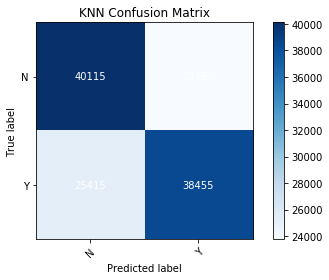

In [65]:
plot_confusion_matrix(cm, ['N', 'Y'], "KNN Confusion Matrix")

(<Figure size 500x400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e0d594e1c8>)

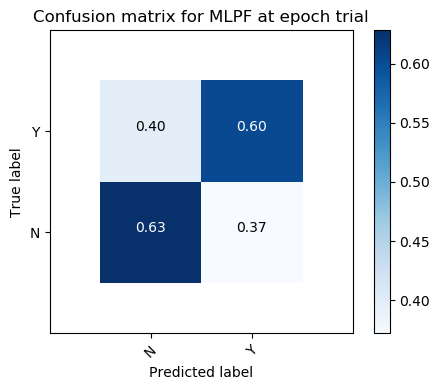

In [66]:
plot_confusion_matrix_2(cm, ['N', 'Y'],"Confusion Matrix 2", "trial",title='Confusion matrix',cmap=None,normalize=True, target=None)

In [67]:
#Can see the model performance and add more features accordingly -- 
#would be good if the performance is greater than 85%

### Test on a product review - Need to write a *function* for this for taking in the user input

The features that we are looking at!
* 'prod_title_comp', 
* 'star_rating', 
* 'rev_title_comp', 
* 'rev_bod_id', 
* 'help_prop_id'

In [68]:
review_body = "this is a good review"
product_title = "Sony Headphones"
review_title = 'Love the product!'

star_rating = 5
helpful_votes = 1
total_votes = 1

In [69]:
test = pd.DataFrame()
test['review_body'] = np.array([review_body])
test['review_title'] = np.array([review_title])
test['product_title'] = np.array([product_title])
test

,review_body,review_title,product_title
0,this is a good review,Love the product!,Sony Headphones


In [70]:
out = df_cleaning(test, 'review_body')
out = df_cleaning(out, 'review_title')
out = df_cleaning(out, 'product_title')
out

,review_body,review_title,product_title,new_review_body,new_review_title,new_product_title
0,this is a good review,Love the product!,Sony Headphones,good review,love product,sony headphone


In [71]:
out['review_body'][0]

'this is a good review'

def get_sentiment_proportions(review):
    """
    create new dataframe with just the proportions for each review
    four columns
    neg_prop, pos_prop, neu_prop, compound_prop and will contain these values
    obtained from the vator sentiment algorithm
    """
    snt = analyser.polarity_scores(review)
    #print(f"{sentence} {str(snt)}")
    neg = snt['neg']
    neu = snt['neu']
    pos = snt['pos']
    #compound = snt['compound']
    return neg, neu, pos

neg, neu, pos = get_sentiment_proportions(out.get("new_review_body").iloc[0])

product_category = convert_to_id(product_category)
product_title = only_compound(product_title)
rev_title = only_compound(review_title)

In [72]:
rev_bod_id = id_for_dictionary(analyser.polarity_scores(out['new_review_body'][0]))
help_prop_id = id_for_prop(helpful_votes / total_votes)
prod_title_comp = only_compound(out['new_product_title'][0])
rev_title_comp = only_compound(out['new_review_title'][0])

Predicted: 'verified_purchase'

User Input: 'prod_title_comp', 'product_category_convert', 'star_rating', 'helpful_votes', 'total_votes', 'neg_prop', 'neu_prop', 'pos_prop'
- 8 fields

In [73]:
rev_input_test = np.array([[prod_title_comp, star_rating, rev_title_comp, rev_bod_id, help_prop_id]])
rev_input_test

array([[0.    , 5.    , 0.6369, 1.    , 1.    ]])

In [74]:
prediction, probabilities = knn_classifier.predict(rev_input_test), knn_classifier.predict_proba(rev_input_test)[0]

In [75]:
prediction

array(['Y'], dtype=object)

In [76]:
probabilities

array([0.45, 0.55])

classifier?

In [77]:
def interpret_prediction(review, pred, proba):
    proba = [round(proba[0], 3), round(proba[1], 3)]
    if prediction[0] == 'Y':
        print(f'"{review}" is predicted to be a VERIFIED review, with {proba[1]*100}% probability of being VERIFIED and {proba[0]*100}% probability of being UNVERIFIED')
    if prediction[0] == 'N':
        print(f'"{review}" is predicted to be an UNVERIFIED review, with {proba[0]*100}% probability of being UNVERIFIED and {proba[1]*100}% probability of being VERIFIED')
        
interpret_prediction(review_test, prediction, probabilities)

NameError: name 'review_test' is not defined

In [78]:
from joblib import dump, load

In [79]:
knn_classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=1,
                     weights='uniform')

In [ ]:
#name = 'knn_working_model.joblib'
#path = 'KNNModelFiles/'
#dump(knn_classifier, path+name)

In [ ]:
#knn_classifier = load(path+name)

In [80]:
name = 'knn_electronics_sampled_model.joblib'
dump(knn_classifier, name)
knn_classifier = load(name)

## Getting Reviews

In [ ]:
# Getting the indices of the reviews that were predicted correctly
ind1 = list((y_test == y_pred) & (y_test == 'N'))#.index(True)
# & (y_test == 'N')
[i for i, x in enumerate(ind1) if x]

In [ ]:
ind1 = 4402
# 3137, 3745
X_test[ind1]

In [ ]:
test = list(X)
test;

In [ ]:
test2 = (test == X_test[ind1])
test2

In [ ]:
ind2 = list(np.all(test2, axis = 1))#.index(True)
ind2
n_lst = [i for i, x in enumerate(ind2) if x]
(n_lst)

In [ ]:
one_file.iloc[313740].to_frame().loc[['review_body', 'review_headline', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'verified_purchase']]

In [ ]:
review_body = "These are great rechargable batteries. Much easier to use than the type I used to have. They work right away - the charger is very easy to use - and they last a long long time!! Great way to do my little part to help the earth and save myself some $$$."
review_title = 'I love an easy way to help the earth!! (and save $)'
product_title = 'Sanyo Eneloop NiMH Battery Charger with 4AA NiMH Rechargable Batteries (Discontinued by Manufacturer)'
star_rating = 5
helpful_votes = 2
total_votes = 4

In [ ]:
test = pd.DataFrame()
test['review_body'] = np.array([review_body])
test['review_title'] = np.array([review_title])
test['product_title'] = np.array([product_title])
test

In [ ]:
out = df_cleaning(test, 'review_body')
out = df_cleaning(out, 'review_title')
out = df_cleaning(out, 'product_title')
out

In [ ]:
rev_bod_id = id_for_dictionary(analyser.polarity_scores(out['new_review_body'][0]))
prop = 1/2
help_prop_id = id_for_prop(prop)
prod_title_comp = only_compound(out['new_product_title'][0])
print(prod_title_comp)
rev_title_comp = only_compound(out['new_review_title'][0])

In [ ]:
rev_input_test = np.array([[prod_title_comp, star_rating, rev_title_comp, rev_bod_id, help_prop_id]])
rev_input_test

In [ ]:
prediction, probabilities = knn_classifier.predict(rev_input_test), knn_classifier.predict_proba(rev_input_test)[0]

In [ ]:
prediction

In [ ]:
probabilities